# Component 2: Vector Quantization (Product Quantization)

In [ ]:
import sys
# Make sure product_quantization.py is in the same folder or in 'Components'
sys.path.append("Components")
from product_quantization import ProductQuantizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional: configure numpy print
np.set_printoptions(precision=4, suppress=True)

print("✓ Libraries loaded.")

✓ Libraries loaded.


In [ ]:
# ============================================
# Component 2: Product Quantization
# Block 2 — Load dense document vectors
# ============================================

# Load the dense vectors from Component 1 (Word2Vec)
doc_vectors = np.load("Data/processed/doc_vectors_w2v.npy")

print("✓ Document vectors loaded.")
print(f"Shape of doc_vectors: {doc_vectors.shape}")

# Optional: load metadata (titles, decades)
metadata = pd.read_csv("Data/processed/doc_metadata.csv")

print(f"✓ Metadata loaded: {metadata.shape[0]} records")
metadata.head(3)

✓ Document vectors loaded.
Shape of doc_vectors: (17830, 200)
✓ Metadata loaded: 17830 records


,title,decade
0,'Gator Bait,1970s
1,...And Justice for All (film),1970s
2,10 (1979 film),1970s


In [ ]:
# ============================================
# Component 2: Product Quantization
# Block 3 — Fit and Encode
# ============================================

# Configuration for PQ
# Input dimensions = 200.
# We split into m=4 subspaces (50 dims each) or m=8 (25 dims each).
# k=256 clusters per subspace (fits in 1 byte/uint8).

n_subvectors = 4
n_clusters = 256

print(f"Initializing PQ with m={n_subvectors} subspaces and k={n_clusters} clusters per subspace.")

pq = ProductQuantizer(n_subvectors=n_subvectors, n_clusters=n_clusters)

# 1. Fit (Train KMeans on each subspace)
print("Training PQ (this might take a moment)...")
pq.fit(doc_vectors)

# 2. Encode (Compress the entire dataset)
print("Encoding database...")
codes = pq.encode(doc_vectors)

print("✓ PQ Model trained and data encoded.")
print(f"Original size (float32): {doc_vectors.nbytes / 1024 / 1024:.2f} MB")
print(f"Compressed size (uint16/8): {codes.nbytes / 1024 / 1024:.2f} MB")

Initializing PQ with m=4 subspaces and k=256 clusters per subspace.
Training PQ (this might take a moment)...
Training PQ: 17830 vectors, 200 dims -> 4 subspaces of dim 50
Training complete.
Encoding database...
✓ PQ Model trained and data encoded.
Original size (float32): 13.60 MB
Compressed size (uint16/8): 0.14 MB


In [ ]:
print("All titles with Index:", list(zip(metadata['title'], metadata.index)))

all titles with Index : [("'Gator Bait", 0), ('...And Justice for All (film)', 1), ('10 (1979 film)', 2), ('11th Victim', 3), ('1776 (film)', 4), ('1941 (film)', 5), ('200 Motels', 6), ('21 Hours at Munich', 7), ('3 Dev Adam', 8), ('3 Women', 9), ('40 Carats (film)', 10), ('92 in the Shade', 11), ('99 and 44/100% Dead', 12), ('A Boy and His Dog (1975 film)', 13), ('A Brand New Life (1973 film)', 14), ('A Bridge Too Far (film)', 15), ('A Bullet for Pretty Boy', 16), ('A Case of Rape', 17), ('A Delicate Balance (film)', 18), ('A Different Story', 19), ('A Force of One', 20), ('A Gunfight', 21), ('A Little Night Music (film)', 22), ('A Little Romance', 23), ('A Man Called Horse (film)', 24), ('A Man, a Woman, and a Killer', 25), ('A Matter of Time (film)', 26), ('A Name for Evil', 27), ('A New Leaf (film)', 28), ('A Night Full of Rain', 29), ('A Perfect Couple', 30), ('A Piece of the Action (film)', 31), ('A Question of Love', 32), ('A Reason to Live, a Reason to Die', 33), ('A Reflection

In [ ]:
# Component 2 — Product Quantization
# Block 4: Example Query

# Choose a query document
QUERY_INDEX = 1

query_vec = doc_vectors[QUERY_INDEX]

print("Query document")
print("-" * 60)
print(f"  index : {QUERY_INDEX}")
print(f"  title : {metadata.loc[QUERY_INDEX, 'title']}")
print(f"  decade: {metadata.loc[QUERY_INDEX, 'decade']}")

# Find nearest neighbors using PQ Search
TOP_N = 10

# pq.search uses Asymmetric Distance Computation
# It returns the top_k indices and the approximate squared distances
indices, distances = pq.search(
    query_vec=query_vec,
    top_k=TOP_N
)

print("\nNearest neighbors (PQ Approximation):")
print("-" * 60)
for rank, (idx, dist) in enumerate(zip(indices, distances), start=1):
    title = metadata.loc[idx, "title"]
    decade = metadata.loc[idx, "decade"]
    print(f"{rank:2d}. idx={idx:5d} | dist={dist:.4f} | {title} ({decade})")

Query document
------------------------------------------------------------
  index : 1
  title : ...And Justice for All (film)
  decade: 1970s

Nearest neighbors (PQ Approximation):
------------------------------------------------------------
 1. idx=    1 | dist=0.0384 | ...And Justice for All (film) (1970s)
 2. idx= 7277 | dist=0.0384 | A Date with Darkness: The Trial and Capture of Andrew Luster (2000s)
 3. idx=17665 | dist=0.0384 | The Trial of the Chicago 7 (2020s)
 4. idx=14133 | dist=0.0384 | Marshall (film) (2010s)
 5. idx= 3476 | dist=0.0397 | Suspect (1987 film) (1980s)
 6. idx= 6014 | dist=0.0397 | Presumed Innocent (film) (1990s)
 7. idx= 3362 | dist=0.0413 | Small Sacrifices (1980s)
 8. idx= 4187 | dist=0.0413 | A Time to Kill (1996 film) (1990s)
 9. idx= 3520 | dist=0.0413 | The Accused (1988 film) (1980s)
10. idx= 6016 | dist=0.0454 | Primal Fear (film) (1990s)


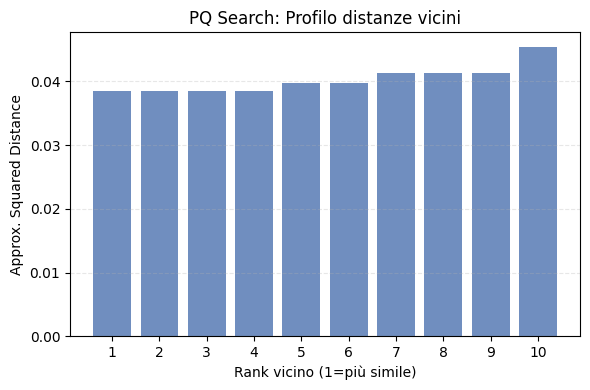

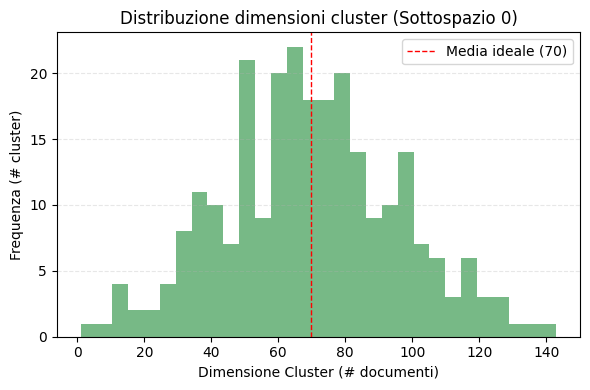

In [ ]:
# Component 2 — Vector Quantization (Product Quantization)
# Block 5: simple visualizations

import matplotlib.pyplot as plt
import numpy as np

# --- 1) Distance profile of the TOP_N neighbors ---
# Note: The ProductQuantizer class returns squared Euclidean distances
plt.figure(figsize=(6, 4))
plt.bar(range(len(distances)), distances, color='#4c72b0', alpha=0.8)
plt.xticks(range(len(distances)), [str(i) for i in range(1, len(distances) + 1)])
plt.xlabel("Neighbor Rank (1=most similar)")
plt.ylabel("Approx. Squared Distance")
plt.title("PQ Search: Neighbor Distance Profile")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- 2) Cluster size distribution (Subspace 0) ---
# In PQ we have 'm' subspaces. Each subspace has its own independent clustering.
# Let's visualize the distribution for the first subspace to check balance.

if hasattr(pq, 'codebook') and pq.codebook is not None:
    # Get codes for the first subspace (column 0)
    # pq.codebook is a matrix (N_docs, n_subvectors)
    subspace_idx = 0
    codes_subspace = pq.codebook[:, subspace_idx]
    
    # Count how many documents end up in each cluster (0...255)
    # n_clusters is typically 256 in PQ
    cluster_counts = np.bincount(codes_subspace, minlength=pq.n_clusters)

    plt.figure(figsize=(6, 4))
    # The histogram shows: "How many clusters have size X?"
    # If well balanced, it should be a tight bell around (N_docs / 256)
    plt.hist(cluster_counts, bins=30, color='#55a868', alpha=0.8)
    plt.xlabel(f"Cluster Size (# documents)")
    plt.ylabel("Frequency (# clusters)")
    plt.title(f"Cluster size distribution (Subspace {subspace_idx})")
    
    # Add a line for the ideal mean
    mean_size = len(codes_subspace) / pq.n_clusters
    plt.axvline(mean_size, color='red', linestyle='dashed', linewidth=1, label=f'Ideal mean ({mean_size:.0f})')
    plt.legend()
    
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Warning: PQ codebook not generated. Run pq.encode() first.")